In [ ]:
import os
import nltk
import pandas as pd
from tqdm import tqdm
import time
from datasets import load_from_disk, Dataset
from transformers import pipeline
from nltk.tokenize import sent_tokenize
from datasets import load_from_disk
import seaborn as sns
import matplotlib.pyplot as plt


In [ ]:
nltk.download('punkt_tab')
nltk.download('punkt')


[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
pre_dataset = load_from_disk("/content/drive/MyDrive/TFG/sent_datasets/pre_dataset_cache")
post_dataset = load_from_disk("/content/drive/MyDrive/TFG/sent_datasets/post_dataset_cache")

## BERT classified frames

In [ ]:
# sometimes requires multiple runs to get the datasets package
!pip install transformers datasets torch

# !pip install transformers torch


### Model benchmark on random 1000 sentences

In [ ]:
import time
from datasets import load_from_disk, Dataset
from transformers import pipeline
from tqdm import tqdm

# 1. Load your datasets
pre_dataset = load_from_disk("/content/drive/MyDrive/TFG/sent_datasets/pre_dataset_cache").shuffle().select(range(500))
post_dataset = load_from_disk("/content/drive/MyDrive/TFG/sent_datasets/post_dataset_cache").shuffle().select(range(500))

# 2. Combine the datasets (optional - useful for one test run)
combined_dataset = Dataset.from_dict({
    "sentence": pre_dataset["sentence"] + post_dataset["sentence"]
})

# 3. Define the frames (candidate labels)
frames = [
    "This sentence defines a problem.",
    "This sentence diagnoses a cause.",
    "This sentence makes a moral judgment.",
    "This sentence suggests a solution."
]

# 4. Define a function to evaluate a model
def evaluate_model(model_name, dataset, frames, batch_size=32):
    print(f"\nEvaluating: {model_name}")
    classifier = pipeline("zero-shot-classification", model=model_name, device=0)

    start_time = time.time()

    all_results = []
    for i in tqdm(range(0, len(dataset), batch_size), desc="Classifying"):
        batch = dataset[i:i + batch_size]["sentence"]
        results = classifier(batch, candidate_labels=frames)
        all_results.extend(results)

    end_time = time.time()
    elapsed = end_time - start_time
    print(f"Time taken for {len(dataset)} sentences: {elapsed:.2f} seconds")

    return all_results


In [ ]:
# List of model names
models = [
    "distilbert-base-uncased",
    "MoritzLaurer/DeBERTa-v3-base-mnli-fever-anli",
    "facebook/bart-large-mnli"
]

# Evaluate each model and store results
model_outputs = {}

for model in models:
    model_outputs[model] = evaluate_model(model, combined_dataset, frames)



Evaluating: distilbert-base-uncased


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Device set to use cuda:0
Failed to determine 'entailment' label id from the label2id mapping in the model config. Setting to -1. Define a descriptive label2id mapping in the model config to ensure correct outputs.
Classifying: 100%|██████████| 63/63 [00:40<00:00,  1.57it/s]


Time taken for 2000 sentences: 40.13 seconds

Evaluating: MoritzLaurer/DeBERTa-v3-base-mnli-fever-anli


Device set to use cuda:0
Classifying: 100%|██████████| 63/63 [03:06<00:00,  2.96s/it]


Time taken for 2000 sentences: 186.26 seconds

Evaluating: facebook/bart-large-mnli


Device set to use cuda:0
Classifying: 100%|██████████| 63/63 [02:44<00:00,  2.61s/it]

Time taken for 2000 sentences: 164.27 seconds


In [ ]:
# Inspect first 5 predictions of each model
for model, outputs in model_outputs.items():
    print(f"\n=== Predictions from {model} ===")
    for i in range(5):
        print(f"Sentence: {combined_dataset[i]['sentence']}")
        print(f"Top Frame: {outputs[i]['labels'][0]}, Score: {outputs[i]['scores'][0]:.2f}")
        print("-" * 40)



=== Predictions from distilbert-base-uncased ===
Sentence: We will make America wealthy again.
Top Frame: This sentence diagnoses a cause., Score: 0.25
----------------------------------------
Sentence: So I want to thank you very much, Senator.
Top Frame: This sentence diagnoses a cause., Score: 0.25
----------------------------------------
Sentence: She failed on Russia, on China, on North Korea.
Top Frame: This sentence diagnoses a cause., Score: 0.25
----------------------------------------
Sentence: Right now, we owe $20 trillion in debt.
Top Frame: This sentence diagnoses a cause., Score: 0.25
----------------------------------------
Sentence: Wouldn't that be a good thing?
Top Frame: This sentence diagnoses a cause., Score: 0.25
----------------------------------------
Sentence: [applause]
No, this wasn't close.
Top Frame: This sentence diagnoses a cause., Score: 0.25
----------------------------------------
Sentence: [laughter]
The Bernie ones were -- they had a lot more spiri

### Framing with final model

In [ ]:
from datasets import Dataset
from transformers import pipeline

#classification pipeline
classifier = pipeline("zero-shot-classification", model="facebook/bart-large-mnli", device=0)    #distilbert-base-uncased

# alt models
# classifier = pipeline("zero-shot-classification", model="distilbert-base-uncased", device=0)
# classifier = pipeline("zero-shot-classification", model="microsoft/MiniLM-L6-H384-uncased")

#possible frames
# frames = ["Defines a problem", "Diagnoses cause", "Makes a moral judgment", "Suggests a solution"]
frames = [
    "This sentence defines a problem.",
    "This sentence diagnoses a cause.",
    "This sentence makes a moral judgment.",
    "This sentence suggests a solution."
]

Device set to use cpu


In [ ]:
def extract_sentences(file_path):
    with open(file_path, 'r', encoding='utf-8') as file:
        text = file.read()
    return sent_tokenize(text)  # Split into sentences


def create_sentence_dataset(file_list):
    all_sentences = []
    for file_path in file_list:
        sentences = extract_sentences(file_path)
        for sentence in sentences:
            all_sentences.append({"sentence": sentence})  # Structure it as a dictionary
    return Dataset.from_list(all_sentences)


def classify_batch(dataset, classifier, frames):
    sentences = dataset["sentence"]  # Extract all sentences from the dataset
    results = classifier(sentences, candidate_labels=frames)  # Classify the batch
    return results


def process_results(results, dataset, collection_name):
    data = []
    for i, result in enumerate(results):
        frame = result['labels'][0]
        score = result['scores'][0]
        data.append({
            "collection": collection_name,
            "sentence": dataset[i]["sentence"],
            "frame": frame,
            "confidence_score": score
        })
    return data


def classify_in_chunks(dataset, classifier, frames, batch_size=32):
    all_results = []
    for i in tqdm(range(0, len(dataset), batch_size), desc="Processing Batches"):
        batch = dataset[i:i+batch_size]["sentence"]  # Get a batch of sentences
        results = classifier(batch, candidate_labels=frames)
        all_results.extend(results)
    return all_results

In [ ]:
# sentence datasets prepared and saved, ready to be loaded

# pre_dataset = create_sentence_dataset(pre_files)
# post_dataset = create_sentence_dataset(post_files)

# pre_dataset.save_to_disk("/content/drive/MyDrive/TFG/sent_datasets/pre_dataset_cache")
# post_dataset.save_to_disk("/content/drive/MyDrive/TFG/sent_datasets/post_dataset_cache")

Saving the dataset (0/1 shards):   0%|          | 0/15651 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/23524 [00:00<?, ? examples/s]

In [ ]:
# Classify in chunks
pre_results = classify_in_chunks(pre_dataset, classifier, frames, batch_size=64)
post_results = classify_in_chunks(post_dataset, classifier, frames, batch_size=64)

# Process and combine
pre_df = pd.DataFrame(process_results(pre_results, pre_dataset, "Pre-Election"))
post_df = pd.DataFrame(process_results(post_results, post_dataset, "Post-Election"))

all_frames_df = pd.concat([pre_df, post_df], ignore_index=True)


Processing Batches:   0%|          | 1/245 [06:47<27:36:57, 407.45s/it]


KeyboardInterrupt: 

In [ ]:
# saving the df with framing to disk
# all_frames_df.to_csv("/content/drive/MyDrive/TFG/Framing_df.csv")

### Results

In [ ]:
# loading framing df or using the last framed

# framing_df = all_frames_df.copy()
framing_df = pd.read_csv("/content/drive/MyDrive/TFG/final_framing.csv")

In [ ]:
framing_df = framing_df.rename(columns={'Unnamed: 0': 'id'})
framing_df["frame"] = framing_df["frame"].str.replace("This sentence ", "").str.rstrip(".")


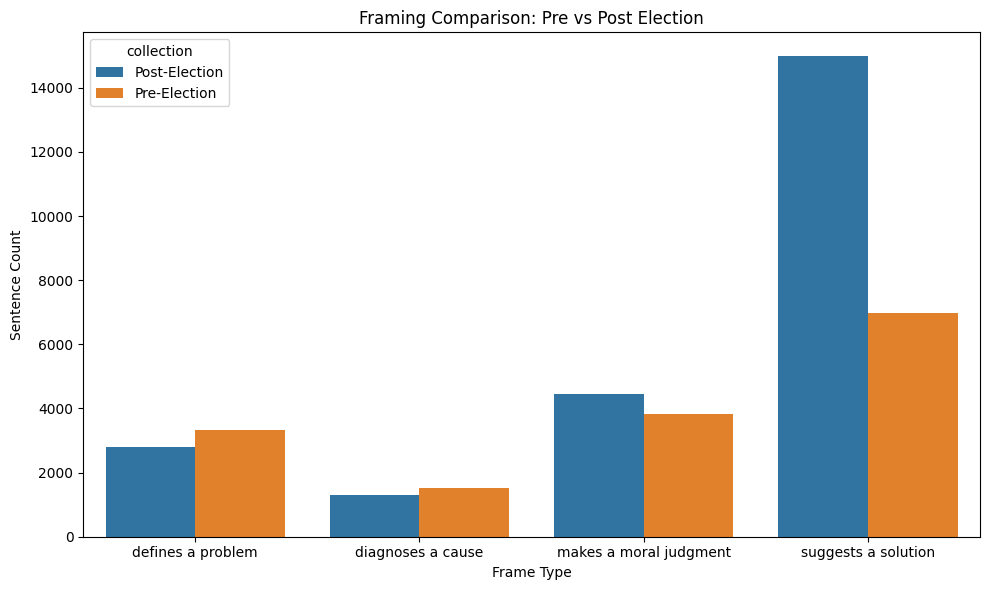

In [ ]:
frame_counts = framing_df.groupby(['collection', 'frame']).size().reset_index(name='count')

# Create a bar plot to visualize the frame frequencies
plt.figure(figsize=(10, 6))
sns.barplot(data=frame_counts, x='frame', y='count', hue='collection')
plt.title('Framing Comparison: Pre vs Post Election')
plt.ylabel('Sentence Count')
plt.xlabel('Frame Type')
plt.tight_layout()
plt.show()

<ipython-input-18-997c67d3a612>:4: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda df: df.assign(percentage=df["count"] / df["count"].sum() * 100))


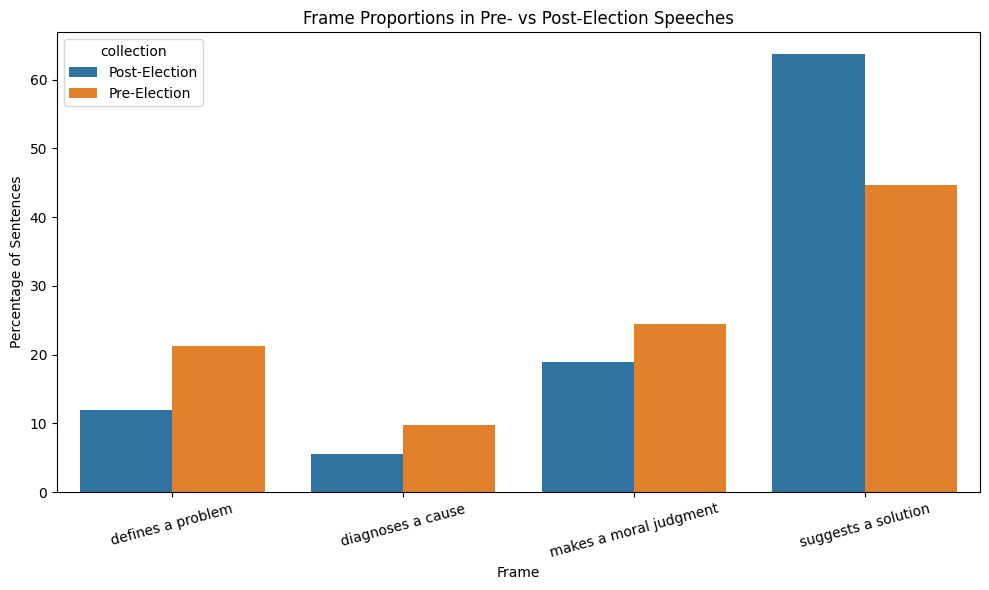

In [ ]:
normalized = (
    frame_counts
    .groupby("collection")
    .apply(lambda df: df.assign(percentage=df["count"] / df["count"].sum() * 100))
    .reset_index(drop=True)
)

plt.figure(figsize=(10, 6))
sns.barplot(data=normalized, x="frame", y="percentage", hue="collection")
plt.title("Frame Proportions in Pre- vs Post-Election Speeches")
plt.ylabel("Percentage of Sentences")
plt.xlabel("Frame")
plt.xticks(rotation=15)
plt.tight_layout()
plt.show()

In [ ]:
top_sentences_per_frame = (
    framing_df
    .sort_values("confidence_score", ascending=False)  # sort by confidence
    .groupby("frame")                                   # group by frame
    .head(200)                                           # take top 20 per frame
    .reset_index(drop=True)                             # clean index
)


# pd.set_option('display.max_rows', 200)


In [ ]:
pd.set_option('display.max_rows', 200)
pd.set_option('display.max_colwidth', None)


In [ ]:
top_sentences_per_frame[top_sentences_per_frame['frame'] == 'suggests a solution']

,id,collection,sentence,frame,confidence_score
0,38234,Post-Election,We’re going to simplify.,suggests a solution,0.946518
2,20338,Post-Election,"And maybe before the press leaves, you can just introduce yourself and your company, and the public will get to see what you’re about.",suggests a solution,0.937036
3,3107,Pre-Election,Let me save you a lot of boredom.,suggests a solution,0.936335
5,18339,Post-Election,Here’s another beauty.,suggests a solution,0.929420
6,34550,Post-Election,"Simplification, where, literally, if we can do it on page; now, in some cases, it may be two pages.",suggests a solution,0.928404
7,22966,Post-Election,We will make it very easy.,suggests a solution,0.928038
9,25732,Post-Election,This is a great plan.,suggests a solution,0.917574
10,21605,Post-Election,This is a great plan.,suggests a solution,0.917574
11,35668,Post-Election,It’s called simplification.,suggests a solution,0.915261
12,33267,Post-Election,It’s called simplification.,suggests a solution,0.915261


In [ ]:
top_sentences_per_frame[top_sentences_per_frame['frame'] == "defines a problem"]

,id,collection,sentence,frame,confidence_score
1,12543,Pre-Election,It's stuck.,defines a problem,0.937653
4,3303,Pre-Election,It is a mess.,defines a problem,0.931584
8,17609,Post-Election,A mess.,defines a problem,0.925678
19,36969,Post-Election,It gets in the way.,defines a problem,0.908727
33,16570,Post-Election,A big mess.,defines a problem,0.889393
68,12440,Pre-Election,This is a criminal act.,defines a problem,0.868199
90,310,Pre-Election,"We have all the cards, but we don't know how to use them.",defines a problem,0.857212
98,830,Pre-Election,It's a barrier that can't be broken.,defines a problem,0.855551
101,6699,Pre-Election,Unfortunately when there is action it's always the wrong decision.,defines a problem,0.854838
102,34560,Post-Election,It’s a very difficult thing.,defines a problem,0.854671


In [ ]:
top_sentences_per_frame[top_sentences_per_frame['frame'] == "diagnoses a cause"]

,id,collection,sentence,frame,confidence_score
81,11840,Pre-Election,It's an agenda.,diagnoses a cause,0.860207
192,33965,Post-Election,And I know why.,diagnoses a cause,0.813148
219,6895,Pre-Election,This is a movement.,diagnoses a cause,0.785107
254,19758,Post-Election,The name says it all: Dreamliner.,diagnoses a cause,0.768433
319,1249,Pre-Election,"I will make you proud of your party and our movement, and that's what it is, is a movement.",diagnoses a cause,0.740828
325,25131,Post-Election,So we knew something was happening.,diagnoses a cause,0.739208
331,3333,Pre-Election,I've been feeling.,diagnoses a cause,0.737768
350,8616,Pre-Election,"It's this attitude of arrogance that explains why Hillary Clinton made her 13 phones disappear – including with a hammer – so the FBI couldn't see them, and why she bleached her emails after a congressional subpoena.",diagnoses a cause,0.732421
352,11237,Pre-Election,We are the campaign of change.,diagnoses a cause,0.732074
360,32973,Post-Election,"And that’s one of the reasons, probably the prime reason, that companies are leaving our country and firing all those people.",diagnoses a cause,0.730483


In [ ]:
top_sentences_per_frame[top_sentences_per_frame['frame'] == "makes a moral judgment"]

,id,collection,sentence,frame,confidence_score
123,24107,Post-Election,"Is he tough, fellas, or a nice guy?",makes a moral judgment,0.851188
162,24381,Post-Election,"Sometimes I look at some of the things I’m signing I say maybe people won’t like it, but I’m doing the right thing.",makes a moral judgment,0.839497
219,20527,Post-Election,I’m against the people that make up stories and make up sources.,makes a moral judgment,0.828926
230,24513,Post-Election,"You witnessed evil, and what you saw is beyond description, beyond any description.",makes a moral judgment,0.826632
236,5336,Pre-Election,"He even proclaimed that we ""love death more then you love life"".",makes a moral judgment,0.818311
237,15214,Pre-Election,"And a lot of people are watching to to see whether or not they are honorable in that respect, because if you look at General Petraeus , what he did is a tiny fraction of what she's done.",makes a moral judgment,0.817681
238,23126,Post-Election,So who’s the bravest person in this room?,makes a moral judgment,0.816969
241,30474,Post-Election,Is he a good husband?,makes a moral judgment,0.814196
249,18435,Post-Election,I find it repulsive.,makes a moral judgment,0.805044
253,10951,Pre-Election,"Hillary Clinton, commonly referred to as Crooked Hillary, thinks that you all of you are deplorable and totally irredeemable.",makes a moral judgment,0.802649


In [ ]:
# Manual filtering of sentences using id

prob_ids=[21369, 1476, 8837, 9166, 9096]
prob_df = top_sentences_per_frame[top_sentences_per_frame['id'].isin(prob_ids)]
prob_df[['sentence', 'frame', 'collection']]

,sentence,frame,collection
365,"It is not compassionate, but reckless to allow uncontrolled entry from places where proper vetting cannot occur.",makes a moral judgment,Post-Election
406,"Ask yourself, who is really the friend of women and the LGBT community, Donald Trump with his actions, or Hillary Clinton with her words?",makes a moral judgment,Pre-Election
501,"The hardworking people she calls deplorable are the most admirable people I know: they are cops and soldiers, teachers and firefighters, young and old, moms and dads, blacks, whites and Latinos – but above everything else, they are all American.",makes a moral judgment,Pre-Election
507,"Her comments are not only reckless, but beneath the dignity of the office she seeks.",makes a moral judgment,Pre-Election
600,"Like how she'll afford to give lifetime welfare and entitlements to illegal immigrants, or how many people will be victimized because of the illegal immigrants that will be released from federal custody – or at the border.",makes a moral judgment,Pre-Election
